# Aumentación de Datos para Imágenes MRI

Este notebook implementa la aumentación de datos para imágenes MRI preprocesadas. La aumentación utiliza la biblioteca Albumentations para generar variaciones de las imágenes originales, incluyendo:

1. Volteos horizontales y verticales
2. Rotaciones
3. Cambios de brillo y contraste
4. Desenfoque gaussiano 
5. CLAHE

Las funciones de utilidad se han movido a `utils.py`.

**Nota**: Este notebook debe ejecutarse después de `preprocesamiento.ipynb`.

In [7]:
# Importar módulos y funciones necesarias
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

# Importar funciones desde utils.py
from utils import (
    augment_image, create_augmented_dataset, 
    plot_augmented
)

In [8]:
# Configuración de rutas y directorios usando Path para compatibilidad con Windows
BASE_DIR = Path(os.path.join(os.getcwd(), 'data', 'dataset'))
PROCESSED_DIR = BASE_DIR / 'Processed'
PROCESSED_TRAIN_DIR = PROCESSED_DIR / 'Training'
AUGMENTED_DIR = PROCESSED_DIR / 'Augmented'

print(f"BASE_DIR: {BASE_DIR}")
print(f"PROCESSED_DIR: {PROCESSED_DIR}")
print(f"PROCESSED_TRAIN_DIR: {PROCESSED_TRAIN_DIR}")
print(f"AUGMENTED_DIR: {AUGMENTED_DIR}")

# Verificar que existe el directorio de imágenes procesadas
if not PROCESSED_TRAIN_DIR.exists():
    print(f"Error: El directorio {PROCESSED_TRAIN_DIR} no existe.")
    print("Ejecute primero el notebook de preprocesamiento.")
else:
    print(f"Directorio de imágenes procesadas encontrado: {PROCESSED_TRAIN_DIR}")
    
    # Crear directorio para imágenes aumentadas si no existe
    if not AUGMENTED_DIR.exists():
        AUGMENTED_DIR.mkdir(parents=True, exist_ok=True)
        print(f"Creado directorio para imágenes aumentadas: {AUGMENTED_DIR}")

BASE_DIR: c:\Users\Administrator\Documents\GitHub\inteligencia_negocios\data\dataset
PROCESSED_DIR: c:\Users\Administrator\Documents\GitHub\inteligencia_negocios\data\dataset\Processed
PROCESSED_TRAIN_DIR: c:\Users\Administrator\Documents\GitHub\inteligencia_negocios\data\dataset\Processed\Training
AUGMENTED_DIR: c:\Users\Administrator\Documents\GitHub\inteligencia_negocios\data\dataset\Processed\Augmented
Directorio de imágenes procesadas encontrado: c:\Users\Administrator\Documents\GitHub\inteligencia_negocios\data\dataset\Processed\Training


Total de imágenes procesadas disponibles: 8582


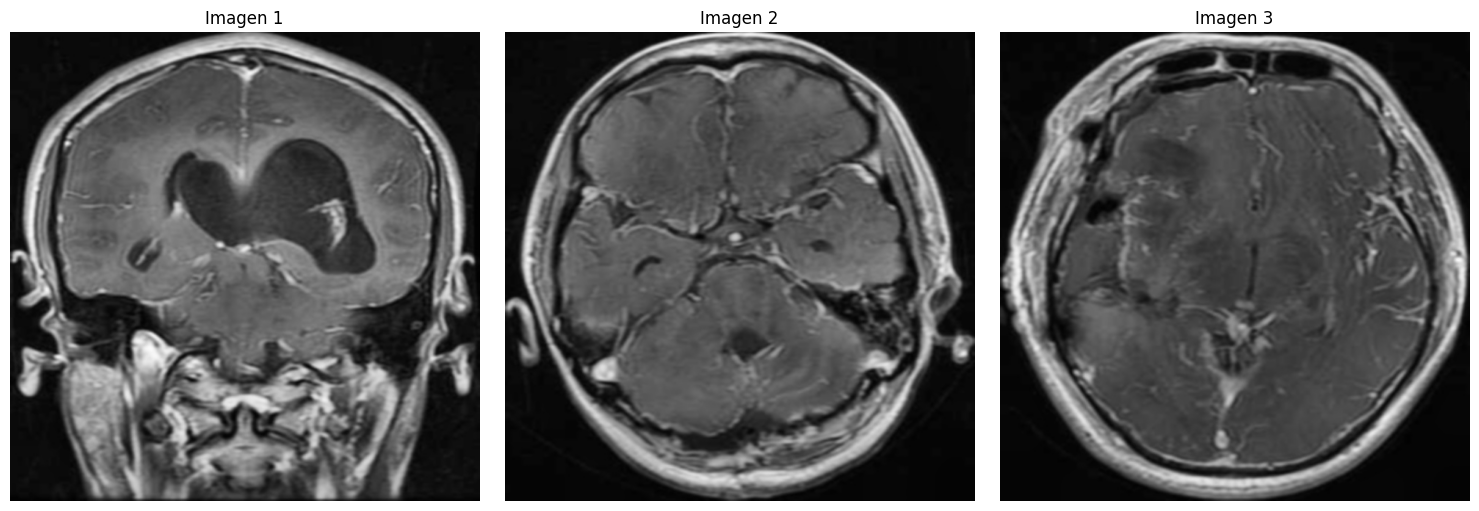

In [9]:
# Obtener información sobre las imágenes procesadas
processed_images = list(PROCESSED_TRAIN_DIR.glob('*.jpg')) + list(PROCESSED_TRAIN_DIR.glob('*.png'))
print(f"Total de imágenes procesadas disponibles: {len(processed_images)}")

# Mostrar algunas imágenes de ejemplo
if len(processed_images) > 0:
    num_examples = min(3, len(processed_images))
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    for i in range(num_examples):
        img = cv2.imread(str(processed_images[i]))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if num_examples == 1:
                axes.imshow(img)
                axes.set_title(f"Imagen {i+1}")
                axes.axis('off')
            else:
                axes[i].imshow(img)
                axes[i].set_title(f"Imagen {i+1}")
                axes[i].axis('off')
    plt.tight_layout()
    plt.show()

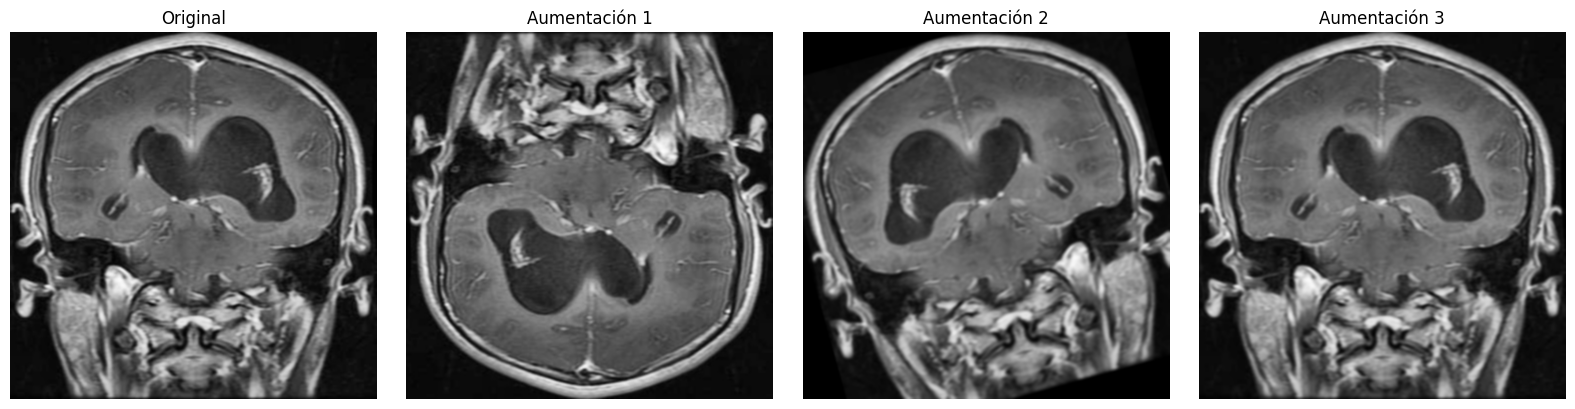

In [10]:
# Demostración de aumentación en una imagen de ejemplo
if len(processed_images) > 0:
    sample_image_path = str(processed_images[0])
    sample_image = cv2.imread(sample_image_path)
    if sample_image is not None:
        # Convertir a RGB para albumentations
        sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
        
        # Obtener etiquetas si existen
        base_name = Path(sample_image_path).stem
        label_path = PROCESSED_TRAIN_DIR / f"{base_name}.txt"
        
        bboxes = []
        class_labels = []
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id, x_center, y_center, width, height = map(float, parts)
                        bboxes.append([x_center, y_center, width, height])
                        class_labels.append(int(class_id))
        
        # Generar y mostrar algunas aumentaciones de ejemplo
        num_examples = 3
        fig, axes = plt.subplots(1, num_examples + 1, figsize=(16, 4))
        
        # Mostrar imagen original
        axes[0].imshow(sample_image_rgb)
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        # Mostrar versiones aumentadas
        for i in range(num_examples):
            aug_image, aug_bboxes, aug_labels = augment_image(sample_image_rgb, bboxes, class_labels)
            axes[i+1].imshow(aug_image)
            axes[i+1].set_title(f"Aumentación {i+1}")
            axes[i+1].axis('off')
            
            # Dibujar bounding boxes si existen
            for bbox, label in zip(aug_bboxes, aug_labels):
                x_center, y_center, width, height = bbox
                x_min = int((x_center - width/2) * aug_image.shape[1])
                y_min = int((y_center - height/2) * aug_image.shape[0])
                x_max = int((x_center + width/2) * aug_image.shape[1])
                y_max = int((y_center + height/2) * aug_image.shape[0])
                rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                    linewidth=1, edgecolor='r', facecolor='none')
                axes[i+1].add_patch(rect)
        
        plt.tight_layout()
        plt.show()

In [13]:
# Ejecutar el proceso de aumentación para todas las imágenes
# Para utilizar la función create_augmented_dataset con objetos Path
def create_augmented_dataset_wrapper(processed_dir, augmented_dir, augmentations_per_image=3):
    create_augmented_dataset(str(processed_dir), str(augmented_dir), augmentations_per_image)

# Descomenta la siguiente línea para generar el dataset aumentado
create_augmented_dataset_wrapper(PROCESSED_TRAIN_DIR, AUGMENTED_DIR, augmentations_per_image=3)

Generando aumentaciones para 8582 imágenes...


100%|██████████| 8582/8582 [03:53<00:00, 36.68it/s]

Aumentación de datos completada. Total de imágenes generadas: 25746


# Verificación del dataset aumentado

Después de ejecutar la aumentación, se recomienda verificar algunas imágenes para asegurar que el proceso funcionó correctamente.

In [12]:
# Verificar las imágenes aumentadas (descomenta después de ejecutar la aumentación)
# augmented_images = list(AUGMENTED_DIR.glob('*.jpg')) + list(AUGMENTED_DIR.glob('*.png'))
# print(f"Total de imágenes aumentadas generadas: {len(augmented_images)}")

# # Mostrar algunas imágenes aumentadas de ejemplo
# if augmented_images:
#     num_examples = min(4, len(augmented_images))
#     fig, axes = plt.subplots(1, num_examples, figsize=(16, 4))
#     for i in range(num_examples):
#         img = cv2.imread(str(augmented_images[i]))
#         if img is not None:
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             axes[i].imshow(img)
#             axes[i].set_title(f"Aumentación {i+1}")
#             axes[i].axis('off')
#     plt.tight_layout()
#     plt.show()

# Resumen y siguientes pasos

El proceso de aumentación de datos permite:

1. Generar variaciones de las imágenes MRI preprocesadas
2. Aumentar la diversidad del conjunto de entrenamiento
3. Mejorar la robustez del modelo final

Para usar este dataset aumentado:
1. Combine las imágenes originales preprocesadas con las imágenes aumentadas, o
2. Use solo las imágenes aumentadas si desea probar su efectividad

El siguiente paso sería entrenar el modelo YOLOv7 con estos datos.